# Python classes (by example): building a tiny waveform `TimeSeries` type

This notebook builds up the same idea in four stages:

1. **Loose variables** (a NumPy array + separate metadata variables)
2. **A dict container** (one object holding data + metadata)
3. **A custom class** (a *new data type* with methods operating on `self`)
4. **ObsPy** (using `obspy.Trace` and its built-in processing methods)

We’ll use a toy “seismic” time series that has:
- a **mean offset**
- a **linear drift** (trend)
- a little **noise**


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# (Optional) make plots a bit nicer in notebooks
plt.rcParams["figure.figsize"] = (10, 3)


## Part 1 — Start simple: array + separate metadata variables

This is the “I have some data and a bunch of related variables” approach.  
It works, but it's easy to lose track of what belongs together.


In [2]:
# --- Create a toy time series with offset + drift ---
np.random.seed(7)

npts = 2000
sampling_rate = 100.0  # Hz
dt = 1.0 / sampling_rate
t = np.arange(npts) * dt

start_time = "2026-02-05T10:00:00"  # just a string for now

# "SEED-like" metadata (strings)
network = "US"
station = "MVO"
location = "00"
channel = "BHZ"

offset = 2.0
drift_per_second = 0.15
noise = 0.2 * np.random.randn(npts)

x = offset + drift_per_second * t + noise  # data array

x[:5], t[:5], sampling_rate, start_time, (network, station, location, channel)


(array([2.33810514, 1.90831253, 2.00956403, 2.08600326, 1.84821539]),
 array([0.  , 0.01, 0.02, 0.03, 0.04]),
 100.0,
 '2026-02-05T10:00:00',
 ('US', 'MVO', '00', 'BHZ'))

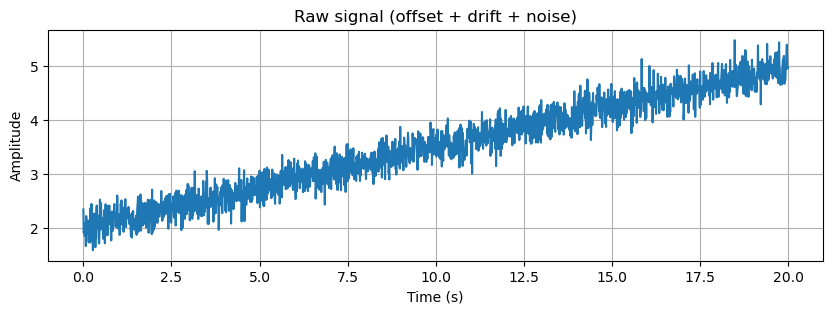

In [3]:
def plot_ts(t, x, title):
    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_ts(t, x, "Raw signal (offset + drift + noise)")


### Functions that operate on raw arrays

We’ll write:
- `demean(x)` subtract mean
- `detrend(x, t)` remove a best-fit line (least squares)
- `downsample(x, factor)` keep every *factor*th sample (**no** anti-aliasing)


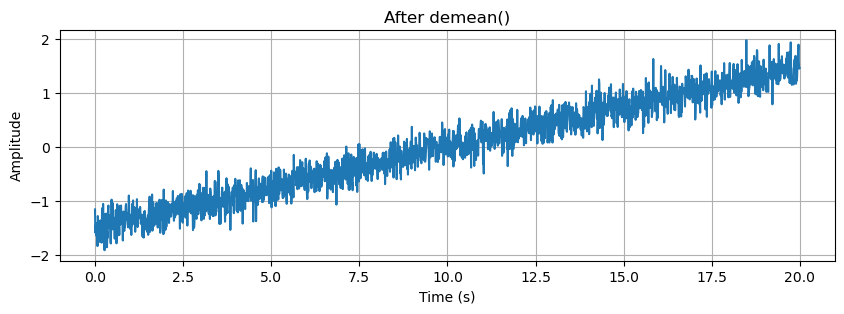

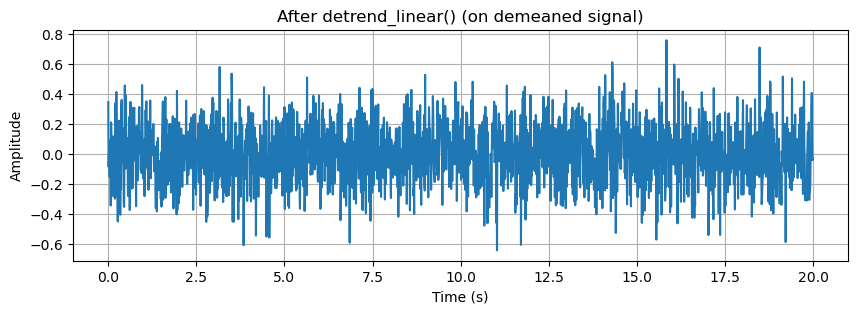

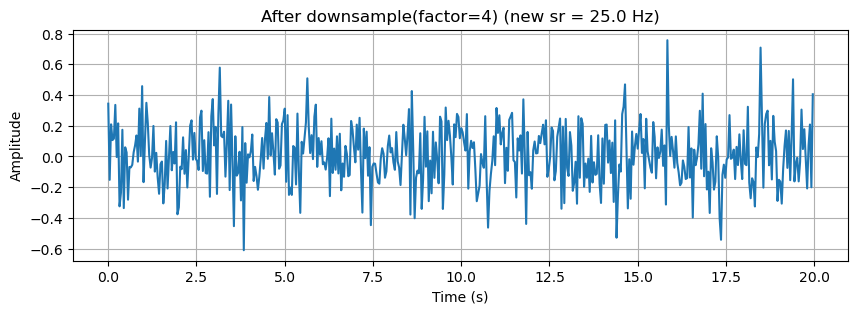

In [4]:
def demean(x):
    """Return a demeaned copy of x."""
    return x - np.mean(x)

def detrend_linear(x, t):
    """Remove a best-fit straight line from x as a function of t."""
    # Fit x ≈ a*t + b
    a, b = np.polyfit(t, x, deg=1)
    trend = a * t + b
    return x - trend

def downsample(x, factor):
    """Downsample by integer factor (no filtering)."""
    if factor <= 0 or int(factor) != factor:
        raise ValueError("factor must be a positive integer")
    factor = int(factor)
    return x[::factor]

# Apply steps
x1 = demean(x)
plot_ts(t, x1, "After demean()")

x2 = detrend_linear(x1, t)
plot_ts(t, x2, "After detrend_linear() (on demeaned signal)")

factor = 4
x3 = downsample(x2, factor)
t3 = downsample(t, factor)
sr3 = sampling_rate / factor
plot_ts(t3, x3, f"After downsample(factor={factor}) (new sr = {sr3:.1f} Hz)")


### What’s awkward here?

We’re carrying around *a lot* of variables:

- data: `x`
- time: `t`
- sampling: `sampling_rate`
- start time: `start_time`
- station codes: `network, station, location, channel`

It’s easy to:
- pass the wrong combination
- forget to update metadata (e.g., sampling rate after downsampling)
- lose provenance in a bigger pipeline


## Part 2 — Bundle everything: a dict “container”

A dict can hold the data and its metadata together in one object.


In [5]:
def init_timeseries(data, sampling_rate, start_time, network, station, location, channel):
    """Create a simple dict container for a time series + metadata."""
    return {
        "data": np.asarray(data, dtype=float),
        "sampling_rate": float(sampling_rate),
        "start_time": str(start_time),
        "network": str(network),
        "station": str(station),
        "location": str(location),
        "channel": str(channel),
    }

ts = init_timeseries(
    data=x,
    sampling_rate=sampling_rate,
    start_time=start_time,
    network=network,
    station=station,
    location=location,
    channel=channel,
)

ts.keys(), (ts["network"], ts["station"], ts["channel"]), ts["data"].shape


(dict_keys(['data', 'sampling_rate', 'start_time', 'network', 'station', 'location', 'channel']),
 ('US', 'MVO', 'BHZ'),
 (2000,))

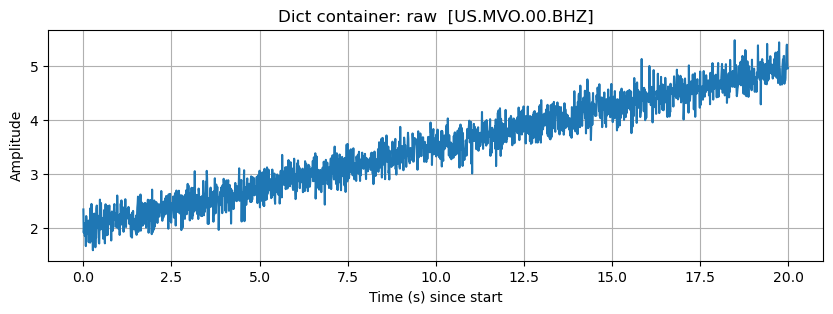

In [6]:
def ts_time_vector(ts):
    """Compute a time vector (seconds since start) from dict container."""
    npts = ts["data"].size
    sr = ts["sampling_rate"]
    return np.arange(npts) / sr

def plot_ts_dict(ts, title):
    t = ts_time_vector(ts)
    plt.figure()
    plt.plot(t, ts["data"])
    plt.xlabel("Time (s) since start")
    plt.ylabel("Amplitude")
    plt.title(title + f"  [{ts['network']}.{ts['station']}.{ts['location']}.{ts['channel']}]")
    plt.grid(True)
    plt.show()

plot_ts_dict(ts, "Dict container: raw")


### Rewrite processing to accept (and return) dicts

We’ll keep these functions “pure”:  
they return *new* dicts rather than modifying the input in-place.


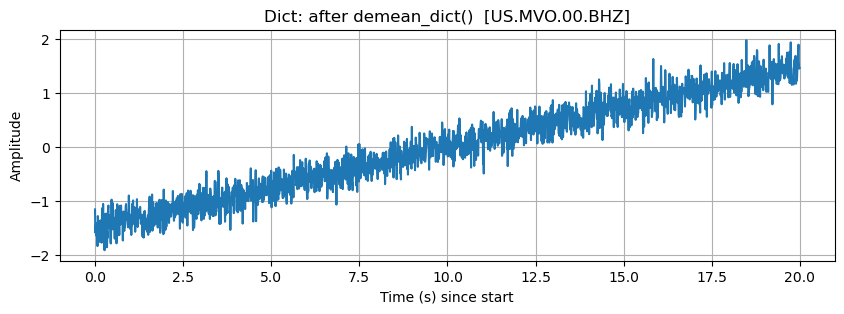

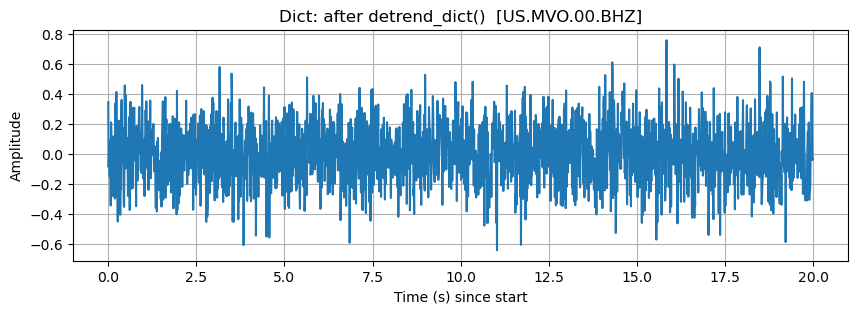

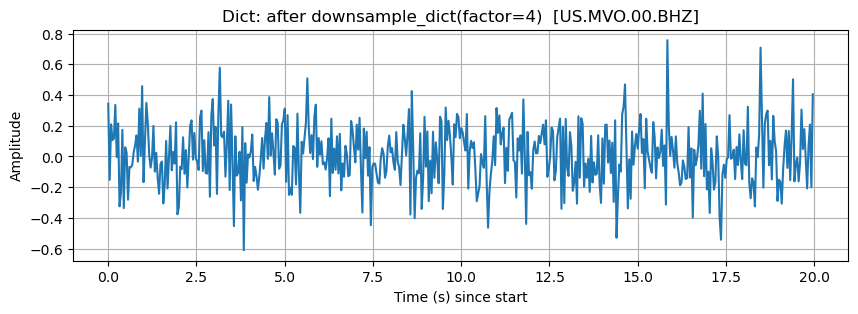

In [7]:
def demean_dict(ts):
    out = dict(ts)  # shallow copy is enough; we'll replace 'data'
    out["data"] = ts["data"] - np.mean(ts["data"])
    return out

def detrend_dict(ts):
    out = dict(ts)
    t = ts_time_vector(ts)
    a, b = np.polyfit(t, ts["data"], deg=1)
    out["data"] = ts["data"] - (a * t + b)
    return out

def downsample_dict(ts, factor):
    factor = int(factor)
    if factor <= 0:
        raise ValueError("factor must be a positive integer")

    out = dict(ts)
    out["data"] = ts["data"][::factor]
    out["sampling_rate"] = ts["sampling_rate"] / factor
    # start_time stays the same (we're just changing sample spacing)
    return out

ts1 = demean_dict(ts)
plot_ts_dict(ts1, "Dict: after demean_dict()")

ts2 = detrend_dict(ts1)
plot_ts_dict(ts2, "Dict: after detrend_dict()")

ts3 = downsample_dict(ts2, 4)
plot_ts_dict(ts3, "Dict: after downsample_dict(factor=4)")


### Why this is better than separate variables

- One object travels through the pipeline.
- Functions can update metadata (sampling rate) consistently.
- Still lightweight.

But:
- there’s no *type* safety (any key can be missing or misspelled)
- no discoverable API (you have to remember key names)
- it gets messy once you have multiple related operations


## Part 3 — Define a new data type: a `TimeSeries` class

A **class** lets you define:
- the data layout (attributes)
- a clean API (methods)
- guarantees/invariants (e.g., always has `data` and `sampling_rate`)


In [8]:
from dataclasses import dataclass, replace

@dataclass(frozen=True)
class TimeSeries:
    """A minimal waveform + metadata container."""
    data: np.ndarray
    sampling_rate: float
    start_time: str
    network: str
    station: str
    location: str
    channel: str

    def __post_init__(self):
        # Ensure data is a float numpy array
        object.__setattr__(self, "data", np.asarray(self.data, dtype=float))
        object.__setattr__(self, "sampling_rate", float(self.sampling_rate))

    @property
    def npts(self) -> int:
        return int(self.data.size)

    @property
    def dt(self) -> float:
        return 1.0 / self.sampling_rate

    def time_vector(self) -> np.ndarray:
        return np.arange(self.npts) / self.sampling_rate

    def id(self) -> str:
        return f"{self.network}.{self.station}.{self.location}.{self.channel}"

    # --- processing methods: return NEW objects (functional style) ---
    def demean(self) -> "TimeSeries":
        return replace(self, data=self.data - np.mean(self.data))

    def detrend(self) -> "TimeSeries":
        t = self.time_vector()
        a, b = np.polyfit(t, self.data, deg=1)
        return replace(self, data=self.data - (a * t + b))

    def downsample(self, factor: int) -> "TimeSeries":
        factor = int(factor)
        if factor <= 0:
            raise ValueError("factor must be a positive integer")
        return replace(
            self,
            data=self.data[::factor],
            sampling_rate=self.sampling_rate / factor,
        )

    def plot(self, title: str):
        t = self.time_vector()
        plt.figure()
        plt.plot(t, self.data)
        plt.xlabel("Time (s) since start")
        plt.ylabel("Amplitude")
        plt.title(title + f"  [{self.id()}]")
        plt.grid(True)
        plt.show()

ts_obj = TimeSeries(
    data=x,
    sampling_rate=sampling_rate,
    start_time=start_time,
    network=network,
    station=station,
    location=location,
    channel=channel,
)

ts_obj.npts, ts_obj.dt, ts_obj.id()


(2000, 0.01, 'US.MVO.00.BHZ')

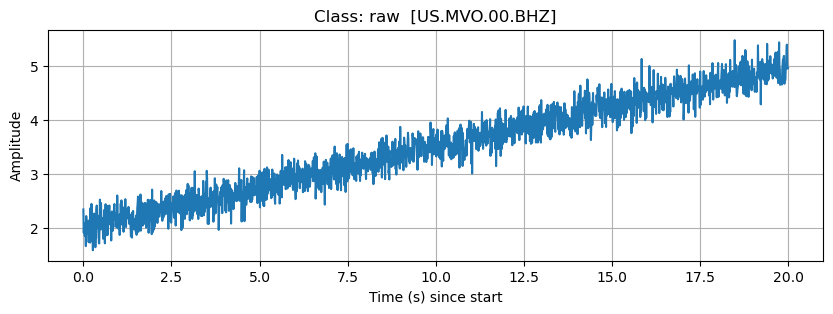

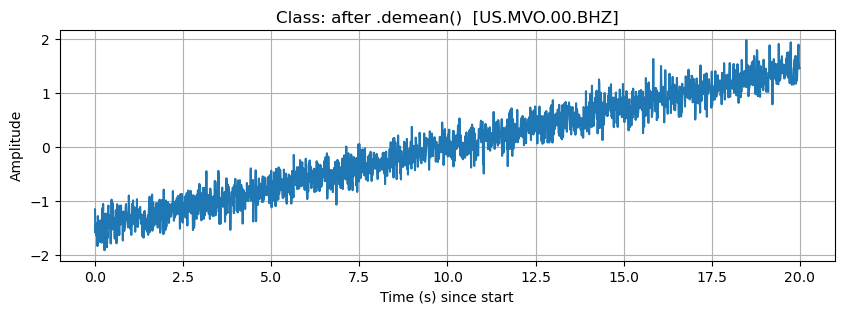

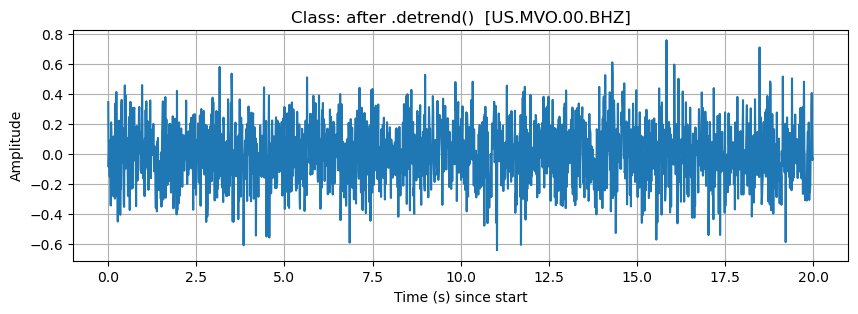

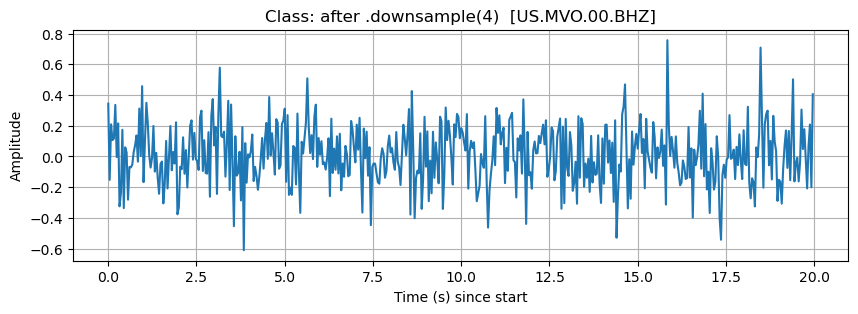

In [ ]:
ts_obj.plot("Class: raw")

ts_obj2 = ts_obj.demean()
ts_obj2.plot("Class: after .demean()")

ts_obj3 = ts_obj2.detrend()
ts_obj3.plot("Class: after .detrend()")

ts_obj4 = ts_obj3.downsample(4)
ts_obj4.plot("Class: after .downsample(4)")


### Why a class is often the sweet spot

- The *object* knows how to operate on itself.
- Metadata stays attached automatically.
- Methods are discoverable (tab completion): `ts_obj.` …
- You can enforce rules in `__post_init__`.

ObsPy does this at scale with `Trace` (one channel) and `Stream` (a collection of traces).


## Part 4 — Doing the same with ObsPy

If you have ObsPy installed:

- `Trace.data` is a NumPy array
- `Trace.stats` holds metadata (incl. `sampling_rate`, `starttime`, `network`, `station`, `location`, `channel`)
- Built-ins: `detrend()`, `decimate()`, `resample()`, `filter()`, …

We’ll create a `Trace` from our synthetic data and run similar steps.

> If ObsPy is *not* installed in your environment, the cell will print a friendly message.


In [10]:
try:
    from obspy import Trace, UTCDateTime
    have_obspy = True
except Exception as e:
    have_obspy = False
    print("ObsPy not available in this environment:", repr(e))

have_obspy


True

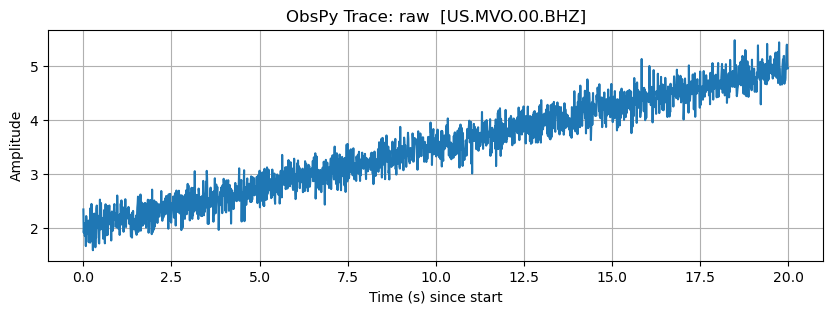

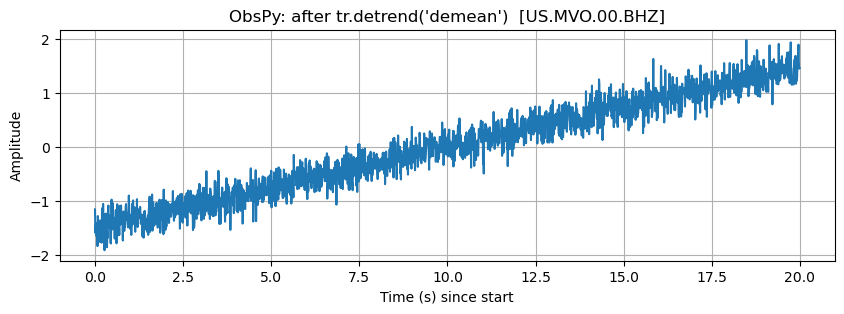

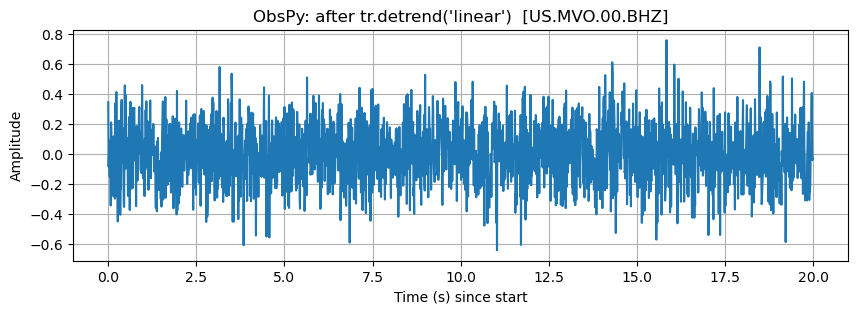

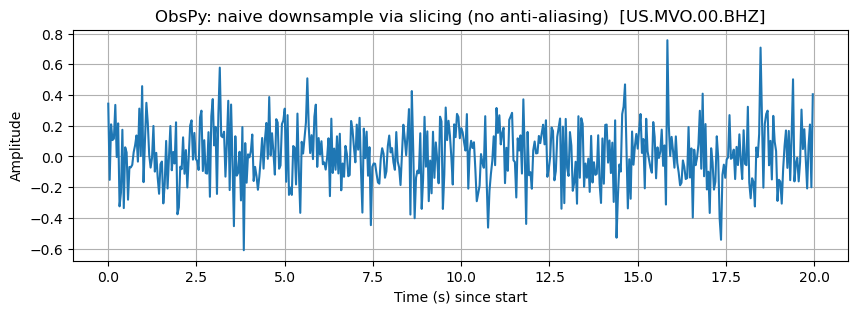

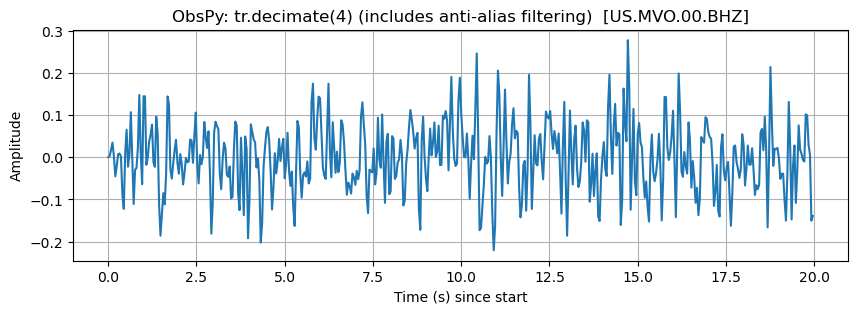

In [11]:
if have_obspy:
    tr = Trace(data=x.copy())
    tr.stats.sampling_rate = sampling_rate
    tr.stats.starttime = UTCDateTime(start_time)
    tr.stats.network = network
    tr.stats.station = station
    tr.stats.location = location
    tr.stats.channel = channel

    # Helper plot for Trace
    def plot_trace(tr, title):
        t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
        plt.figure()
        plt.plot(t, tr.data)
        plt.xlabel("Time (s) since start")
        plt.ylabel("Amplitude")
        plt.title(title + f"  [{tr.id}]")
        plt.grid(True)
        plt.show()

    plot_trace(tr, "ObsPy Trace: raw")

    tr2 = tr.copy()
    tr2.detrend("demean")   # subtract mean
    plot_trace(tr2, "ObsPy: after tr.detrend('demean')")

    tr3 = tr2.copy()
    tr3.detrend("linear")   # remove linear trend
    plot_trace(tr3, "ObsPy: after tr.detrend('linear')")

    # Downsample in ObsPy: decimate includes filtering by default.
    # Since earlier we ignored anti-aliasing, we'll show two options:
    # 1) naive slice (like we did before)
    tr4_naive = tr3.copy()
    tr4_naive.data = tr4_naive.data[::4]
    tr4_naive.stats.sampling_rate = tr4_naive.stats.sampling_rate / 4
    plot_trace(tr4_naive, "ObsPy: naive downsample via slicing (no anti-aliasing)")

    # 2) proper decimate with a filter (recommended in real work)
    tr4 = tr3.copy()
    tr4.decimate(factor=4, no_filter=False, strict_length=False)
    plot_trace(tr4, "ObsPy: tr.decimate(4) (includes anti-alias filtering)")
else:
    print("Skipping ObsPy section because ObsPy isn't installed here.")


## Wrap-up

You’ve now seen the same idea expressed as:

- **loose variables** → quick and dirty, but easy to mis-handle
- **dict container** → bundles data+metadata but keys are fragile
- **class** → a clear, discoverable *new data type* (your own mini-`Trace`)
- **ObsPy** → the full-featured version used in seismology workflows

### A tiny exercise (optional)
1. Add a `taper()` method to `TimeSeries` (e.g., a cosine taper on 5% of samples).
2. Add a `copy()` method (if you switch `frozen=True` to `frozen=False`).
3. Add validation: enforce `sampling_rate > 0` and `data.ndim == 1`.
